In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# model selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 

In [2]:
df = pd.read_csv('raw_data.csv')

In [3]:
df.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,Shield,Club,PJ,G,E,P,GF,GC,+/-,Pto.
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,...,NaN,Paris Saint-Germain,38,26,8,4,90,36,54,86
1,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,...,NaN,Paris Saint-Germain,38,26,8,4,90,36,54,86
2,231747,https://sofifa.com/player/231747/kylian-mbappe...,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,95,194000000.0,230000.0,22,...,NaN,Paris Saint-Germain,38,26,8,4,90,36,54,86
3,230621,https://sofifa.com/player/230621/gianluigi-don...,G. Donnarumma,Gianluigi Donnarumma,GK,89,93,119500000.0,110000.0,22,...,NaN,Paris Saint-Germain,38,26,8,4,90,36,54,86
4,155862,https://sofifa.com/player/155862/sergio-ramos-...,Sergio Ramos,Sergio Ramos García,CB,88,88,24000000.0,115000.0,35,...,NaN,Paris Saint-Germain,38,26,8,4,90,36,54,86


In [30]:
print(df.shape)
df.dtypes

(6850, 113)


player_url           object
short_name           object
long_name            object
player_positions     object
overall               int64
                     ...   
+/-                   int64
Pto.                  int64
PPP                 float64
GFPP                float64
GCPP                float64
Length: 113, dtype: object

In [5]:
# delete the columns full of NaN and columns with duplicate or unnecessary information
df = df.dropna(axis=1, how='all')
df = df.drop(['Club','sofifa_id', 'club_team_id', 'league_level','club_jersey_number',
                                  'club_contract_valid_until', 'nationality_id', 'nation_team_id',
                                  'nation_jersey_number'], axis=1)

In [7]:
df.groupby('league_name')['international_reputation'].describe()

,count,mean,std,min,25%,50%,75%,max
league_name,,,,,,,,
Belgian Jupiler Pro League,488.0,1.038934,0.223194,1.0,1.0,1.0,1.0,3.0
Danish Superliga,318.0,1.003145,0.056077,1.0,1.0,1.0,1.0,2.0
English Premier League,652.0,1.493865,0.772984,1.0,1.0,1.0,2.0,5.0
French Ligue 1,577.0,1.362218,0.652581,1.0,1.0,1.0,2.0,5.0
German 1. Bundesliga,551.0,1.437387,0.692282,1.0,1.0,1.0,2.0,5.0
Holland Eredivisie,492.0,1.071138,0.314323,1.0,1.0,1.0,1.0,4.0
Italian Serie A,563.0,1.516874,0.743405,1.0,1.0,1.0,2.0,5.0
Polish T-Mobile Ekstraklasa,496.0,1.008065,0.109800,1.0,1.0,1.0,1.0,3.0
Portuguese Liga ZON SAGRES,505.0,1.075248,0.342553,1.0,1.0,1.0,1.0,4.0


In [8]:
# drop feature we cannot to scale.
df = df.drop(['international_reputation'], axis=1)

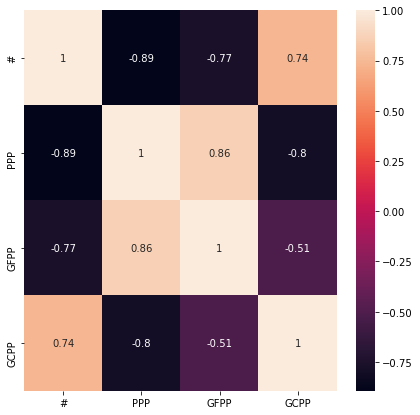

In [9]:
# Select response variables. By having leagues of different sizes, relativize with points and goals per game.

df['PPP'] = df['Pto.']/df['PJ']
df['GFPP'] = df['GF']/df['PJ']
df['GCPP'] = df['GC']/df['PJ']


response_vars = df[['league_name','club_name','#','PPP','GFPP','GCPP']]
response_vars['#'].values.reshape(-1,1)
response_vars_grouped = response_vars.groupby(['league_name','club_name']).agg('mean')
response_vars_grouped

cor_matrix = response_vars_grouped.corr()
plt.figure(figsize=(7,7))
sns.heatmap(cor_matrix, annot = True)
plt.show()

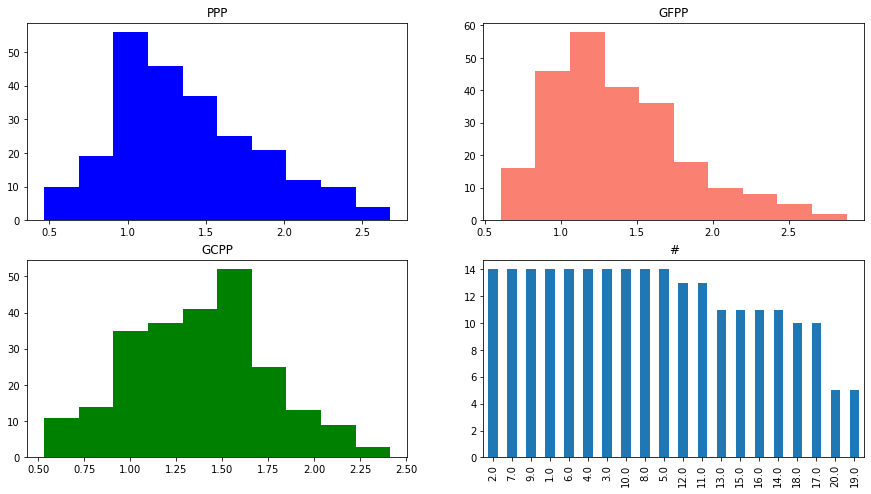

We will rule out position as a response variable since 
      not all leagues have the same teams and, as we have seen, 
      it has a very high correlation with points per game.


In [31]:
# Plot response variables distributions

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,8))

ax1.hist(response_vars_grouped['PPP'], color = 'blue')
ax1.set_title('PPP')

ax2.hist(response_vars_grouped['GFPP'], color = 'salmon')
ax2.set_title('GFPP')

ax3.hist(response_vars_grouped['GCPP'], color = 'green')
ax3.set_title('GCPP')

ax4 = response_vars_grouped['#'].value_counts().plot.bar()
ax4.set_title('#')

plt.show()

print('''We will rule out position as a response variable since 
      not all leagues have the same teams and, as we have seen, 
      it has a very high correlation with points per game.''')

In [26]:
# Prediction variables selection

predict_vars = df.select_dtypes(include='number')
predict_vars = predict_vars.drop(predict_vars.iloc[:,51::], axis=1)
predict_vars

,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,weak_foot,skill_moves,release_clause_eur,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,93,93,78000000.0,320000.0,34,170,72,4,4,144300000.0,...,96,20,35,24,6,11,15,14,8,NaN
1,91,91,129000000.0,270000.0,29,175,68,5,5,238700000.0,...,93,35,32,29,9,9,15,15,11,NaN
2,91,95,194000000.0,230000.0,22,182,73,4,5,373500000.0,...,88,26,34,32,13,5,7,11,6,NaN
3,89,93,119500000.0,110000.0,22,196,90,3,1,230000000.0,...,68,20,14,16,91,83,79,85,90,52.0
4,88,88,24000000.0,115000.0,35,184,82,3,3,44400000.0,...,88,84,89,91,11,8,9,7,11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6845,58,65,425000.0,800.0,21,186,75,3,2,659000.0,...,51,27,27,25,15,10,9,13,5,NaN
6846,55,69,300000.0,750.0,20,171,69,2,2,593000.0,...,41,36,46,42,7,5,5,7,12,NaN
6847,55,59,140000.0,750.0,26,175,73,2,1,200000.0,...,31,8,10,10,54,56,58,54,56,28.0
6848,54,61,180000.0,600.0,23,190,83,2,1,279000.0,...,18,9,11,11,56,55,54,50,56,21.0


In [12]:
# Scale variables grouping by league

for col in predict_vars.columns:
    predict_vars[col] = predict_vars[col].values.reshape(-1,1)
predict_vars_league = pd.merge(df['league_name'], predict_vars, left_index=True, right_index=True)

predict_vars_norm = predict_vars_league.groupby('league_name').transform(lambda x: (x-x.min())/(x.max()-x.min()))
predict_vars_norm = pd.merge(df[['league_name','club_name']], predict_vars_norm, left_index=True, right_index=True)

predict_vars_norm_grouped = predict_vars_norm.groupby(['league_name','club_name']).agg('mean')
predict_vars_norm_grouped

overall  potential  \
league_name                club_name                                        
Belgian Jupiler Pro League Club Brugge KV             0.693122   0.690051   
                           K Beerschot VA             0.480110   0.466931   
                           KAA Gent                   0.603175   0.512755   
                           KAS Eupen                  0.458689   0.445055   
                           KRC Genk                   0.637037   0.701429   
...                                                        ...        ...   
Turkish Süper Lig          Yeni Malatyaspor           0.447436   0.463018   
                           Yukatel Kayserispor        0.506667   0.414103   
                           Çaykur Rizespor            0.514815   0.454416   
                           İstanbul Başakşehir FK     0.600000   0.547009   
                           İttifak Holding Konyaspor  0.525000   0.407051   

                                                      value_eur  wage_eur  \
league_name                club_name                                        
Belgian Jupiler Pro League Club Brugge KV              0.214122  0.307109   
                           K Beerschot VA              0.045120  0.085012   
                           KAA Gent                    0.071441  0.207610   
                           KAS Eupen                   0.044283  0.066139   
                           KRC Genk                    0.180887  0.169607   
...                                                         ...       ...   
Turkish Süper Lig          Yeni Malatyaspor            0.045840  0.027384   
                           Yukatel Kayserispor         0.045052  0.036138   
                           Çaykur Rizespor             0.051084  0.052104   
                           İstanbul Başakşehir FK      0.114660  0.128851   
                           İttifak Holding Konyaspor   0.049819  0.042880   

                                                           age  height_cm  \
league_name                club_name                                        
Belgian Jupiler Pro League Club Brugge KV             0.340136   0.603480   
                           K Beerschot VA             0.352734   0.557455   
                           KAA Gent                   0.426871   0.546703   
                           KAS Eupen                  0.368132   0.530572   
                           KRC Genk                   0.262857   0.499487   
...                                                        ...        ...   
Turkish Süper Lig          Yeni Malatyaspor           0.327759   0.579960   
                           Yukatel Kayserispor        0.456522   0.522807   
                           Çaykur Rizespor            0.428341   0.595517   
                           İstanbul Başakşehir FK     0.457327   0.580897   
                           İttifak Holding Konyaspor  0.469203   0.611842   

                                                      weight_kg  weak_foot  \
league_name                club_name                                         
Belgian Jupiler Pro League Club Brugge KV              0.620821   0.517857   
                           K Beerschot VA              0.589441   0.527778   
                           KAA Gent                    0.602584   0.544643   
                           KAS Eupen                   0.553191   0.500000   
                           KRC Genk                    0.545532   0.540000   
...                                                         ...        ...   
Turkish Süper Lig          Yeni Malatyaspor            0.537475   0.413462   
                           Yukatel Kayserispor         0.490598   0.500000   
                           Çaykur Rizespor             0.539411   0.462963   
                           İstanbul Başakşehir FK      0.559354   0.481481   
                           İttifak Holding Konyaspor   0.561966   0.500000   

                                  

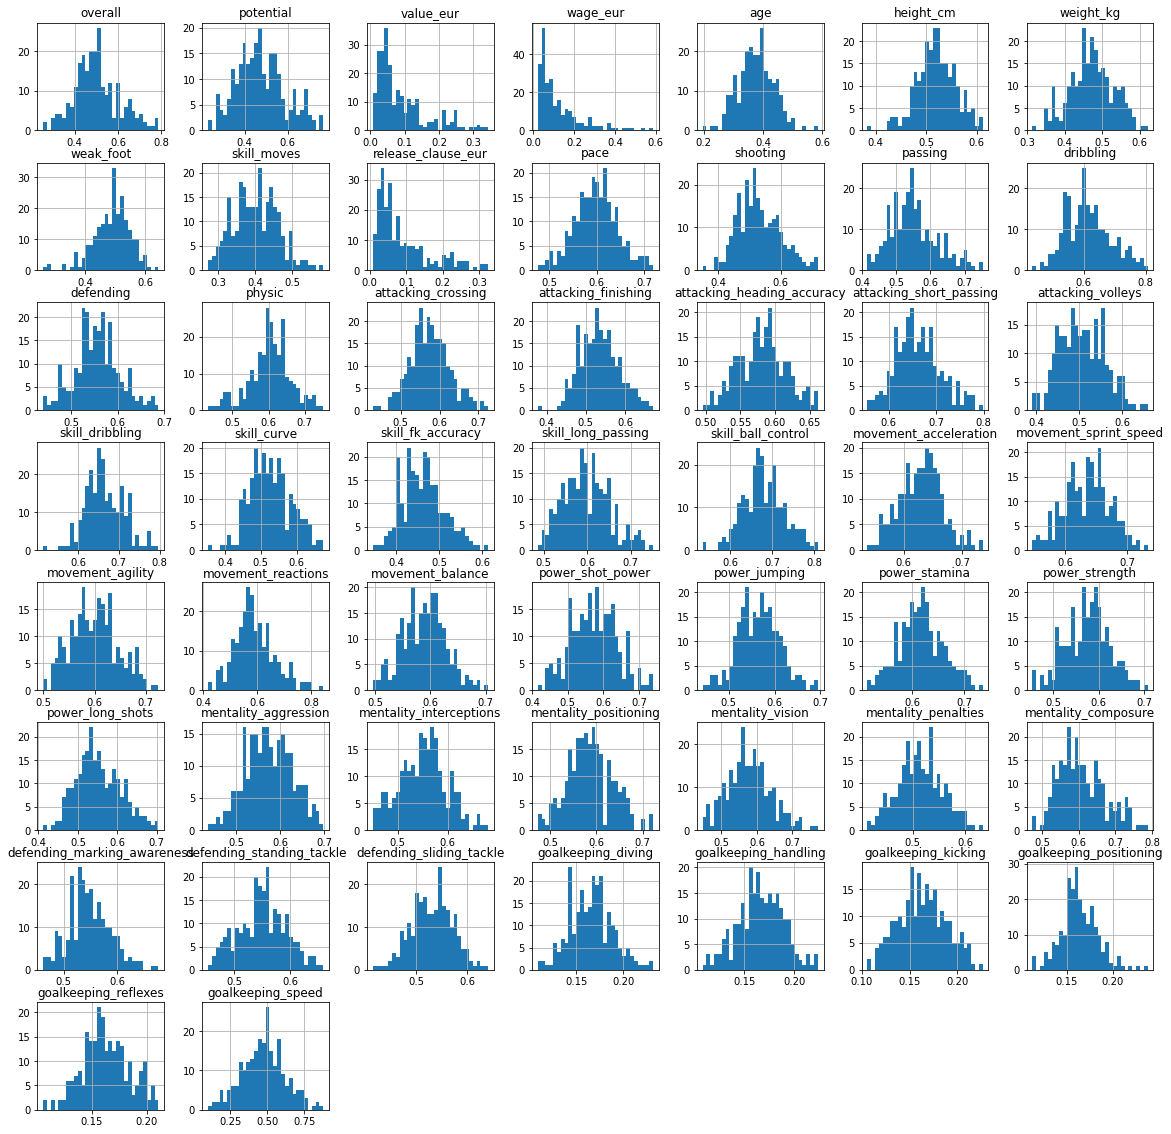

In [13]:
# Plot predict variables distribuiton
predict_vars_norm_grouped.hist(bins=30, figsize=(20, 20))
plt.show()

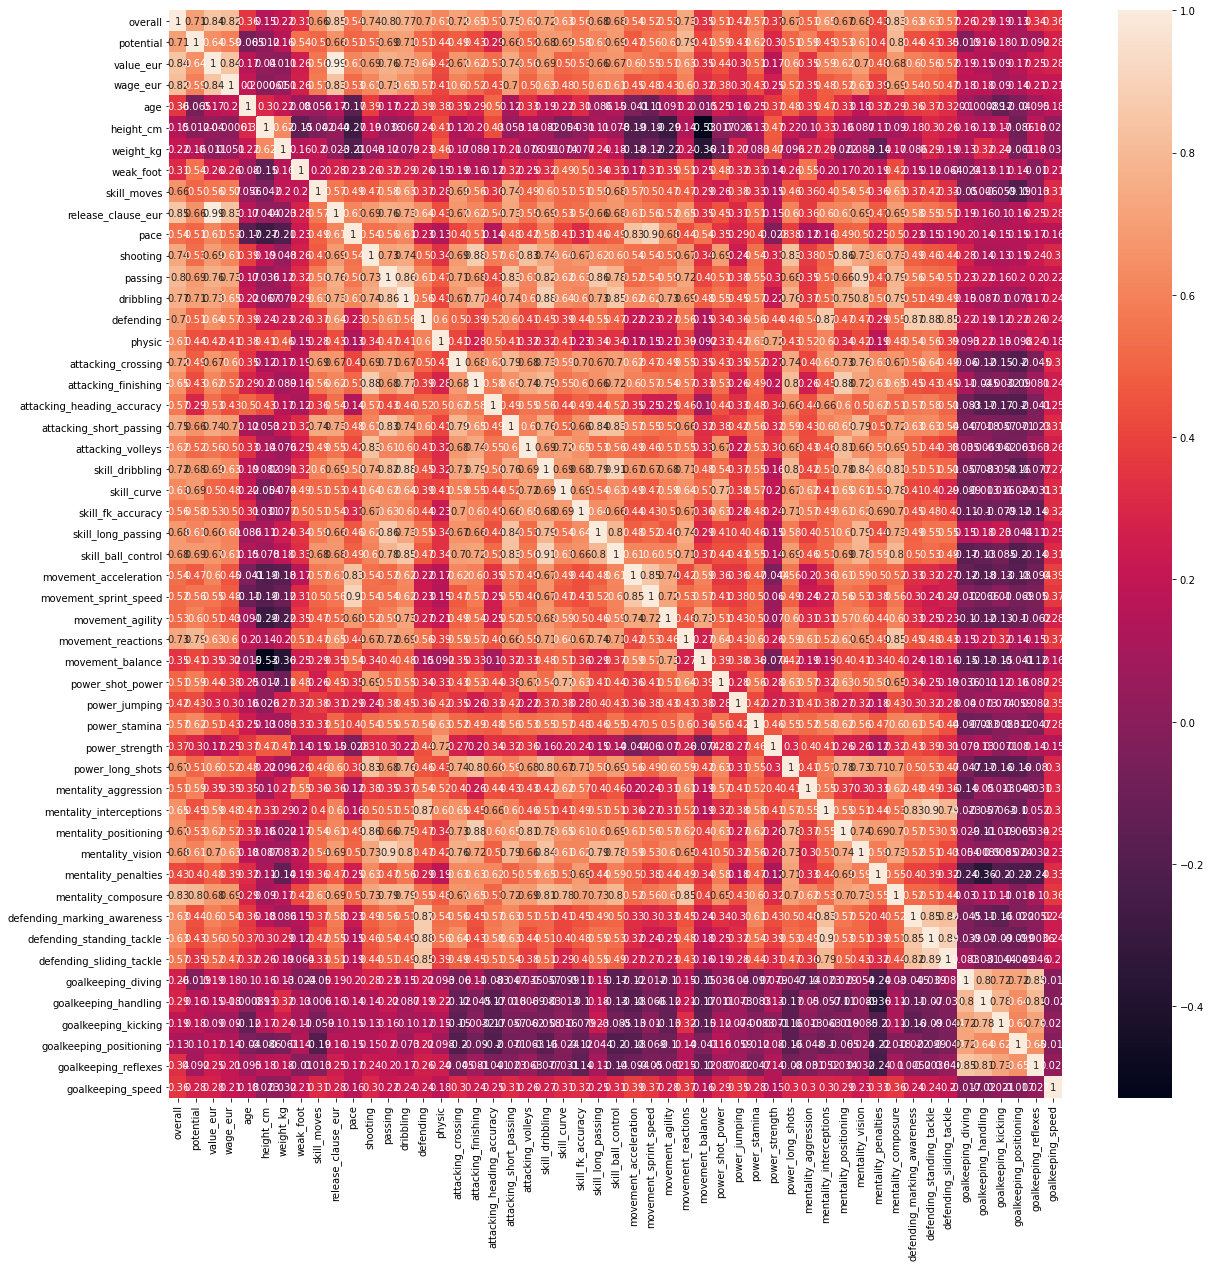

In [14]:
# correlation matrix to drop high correlated features
cor_matrix = predict_vars_norm_grouped.corr()
plt.figure(figsize=(20,20))
sns.heatmap(cor_matrix, annot = True)
plt.show()

In [15]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

In [16]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['release_clause_eur']


In [17]:
predict_vars_norm_grouped = predict_vars_norm_grouped.drop(to_drop, axis=1)
predict_vars_norm_grouped

overall  potential  \
league_name                club_name                                        
Belgian Jupiler Pro League Club Brugge KV             0.693122   0.690051   
                           K Beerschot VA             0.480110   0.466931   
                           KAA Gent                   0.603175   0.512755   
                           KAS Eupen                  0.458689   0.445055   
                           KRC Genk                   0.637037   0.701429   
...                                                        ...        ...   
Turkish Süper Lig          Yeni Malatyaspor           0.447436   0.463018   
                           Yukatel Kayserispor        0.506667   0.414103   
                           Çaykur Rizespor            0.514815   0.454416   
                           İstanbul Başakşehir FK     0.600000   0.547009   
                           İttifak Holding Konyaspor  0.525000   0.407051   

                                                      value_eur  wage_eur  \
league_name                club_name                                        
Belgian Jupiler Pro League Club Brugge KV              0.214122  0.307109   
                           K Beerschot VA              0.045120  0.085012   
                           KAA Gent                    0.071441  0.207610   
                           KAS Eupen                   0.044283  0.066139   
                           KRC Genk                    0.180887  0.169607   
...                                                         ...       ...   
Turkish Süper Lig          Yeni Malatyaspor            0.045840  0.027384   
                           Yukatel Kayserispor         0.045052  0.036138   
                           Çaykur Rizespor             0.051084  0.052104   
                           İstanbul Başakşehir FK      0.114660  0.128851   
                           İttifak Holding Konyaspor   0.049819  0.042880   

                                                           age  height_cm  \
league_name                club_name                                        
Belgian Jupiler Pro League Club Brugge KV             0.340136   0.603480   
                           K Beerschot VA             0.352734   0.557455   
                           KAA Gent                   0.426871   0.546703   
                           KAS Eupen                  0.368132   0.530572   
                           KRC Genk                   0.262857   0.499487   
...                                                        ...        ...   
Turkish Süper Lig          Yeni Malatyaspor           0.327759   0.579960   
                           Yukatel Kayserispor        0.456522   0.522807   
                           Çaykur Rizespor            0.428341   0.595517   
                           İstanbul Başakşehir FK     0.457327   0.580897   
                           İttifak Holding Konyaspor  0.469203   0.611842   

                                                      weight_kg  weak_foot  \
league_name                club_name                                         
Belgian Jupiler Pro League Club Brugge KV              0.620821   0.517857   
                           K Beerschot VA              0.589441   0.527778   
                           KAA Gent                    0.602584   0.544643   
                           KAS Eupen                   0.553191   0.500000   
                           KRC Genk                    0.545532   0.540000   
...                                                         ...        ...   
Turkish Süper Lig          Yeni Malatyaspor            0.537475   0.413462   
                           Yukatel Kayserispor         0.490598   0.500000   
                           Çaykur Rizespor             0.539411   0.462963   
                           İstanbul Başakşehir FK      0.559354   0.481481   
                           İttifak Holding Konyaspor   0.561966   0.500000   

                                  

In [18]:
# Feature Selection

featureScores_d = {}

X = predict_vars_norm_grouped
feature_names = predict_vars_norm_grouped.columns

for col in response_vars_grouped[['PPP','GFPP','GCPP']]:
    
    y = response_vars_grouped.loc[:,col]

    # Feature evaluation
    bestfeaturesIM = SelectKBest(score_func=mutual_info_regression, k='all').fit(X,y)
    dfscoresIM = pd.DataFrame(bestfeaturesIM.scores_)
        
    featureScores = pd.concat([pd.DataFrame(feature_names),dfscoresIM],axis=1)
    featureScores.columns = ['Caracteristica','IM']

    featureScores = featureScores.sort_values('IM', ascending= False).reset_index(drop=True)
    featureScores_d[col] = featureScores


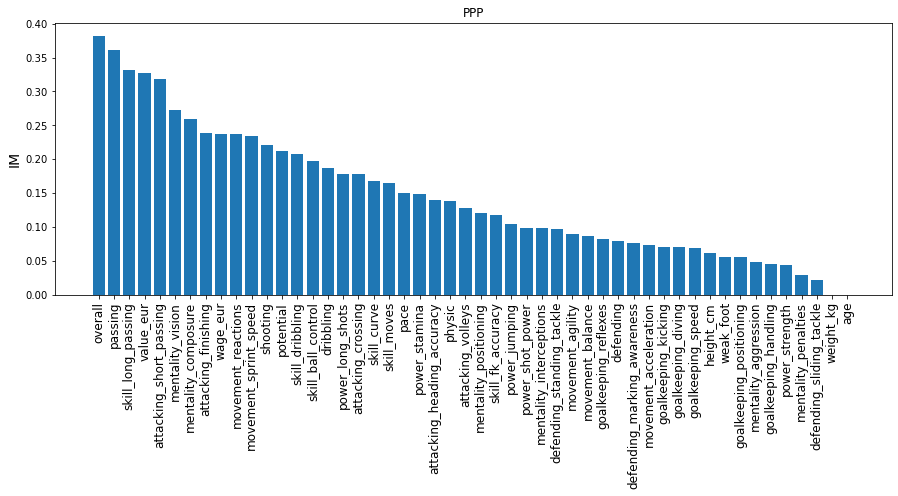

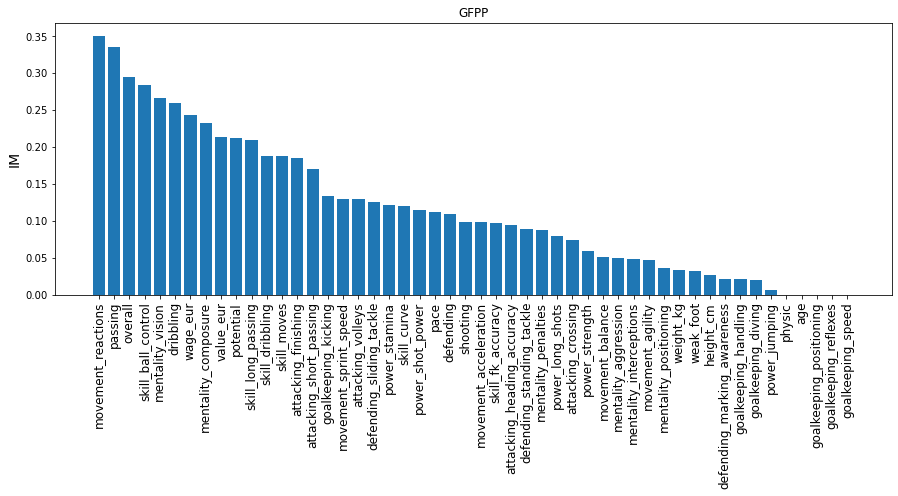

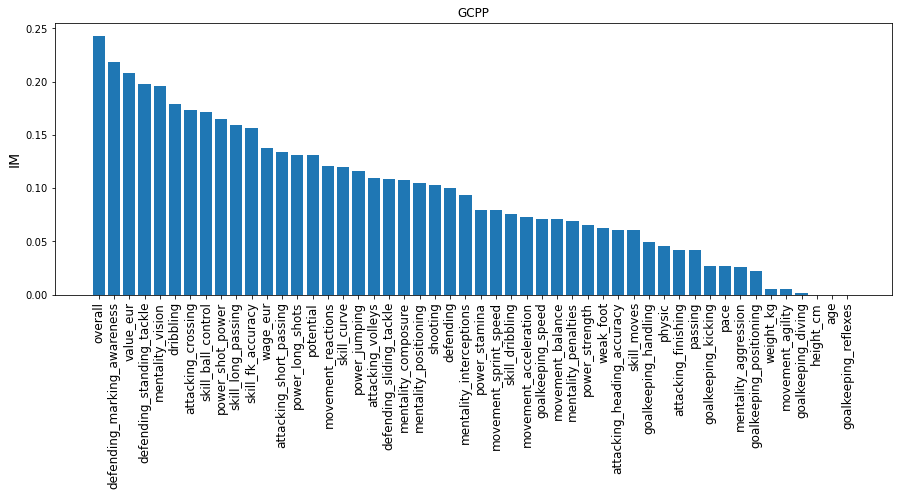

In [19]:
# Plot Feature impact

for response_var, featureScores in featureScores_d.items():

    plt.figure(figsize=(15,5))
    xs=np.linspace(start=0, stop=len(featureScores)-1,num=len(featureScores))
    plt.bar(xs, featureScores['IM'].values)
    plt.xticks(xs, featureScores['Caracteristica'], rotation=90, fontsize=12)
    plt.ylabel('IM', fontsize=14)
    plt.title(response_var)
    plt.show()

In [27]:
# Most impact Features

X_d = {}

for response_var, featureScores in featureScores_d.items():
    if response_var == 'PPP':
        X_d[response_var] = featureScores.iloc[0:24,0].values.tolist()
    if response_var == 'GFPP':
        X_d[response_var] = featureScores.iloc[0:15,0].values.tolist()
    if response_var == 'GCPP':
        X_d[response_var] = featureScores.iloc[0:18,0].values.tolist()
    print('The main features that influence the resopnse variable ',response_var,' are: ',X_d[response_var])
    print('')

common_features = list(set(X_d['PPP']).intersection(X_d['GFPP']).intersection(X_d['GCPP']))
print('The common features that influence all the response variables are: ',common_features)

The main features that influence the resopnse variable  PPP  are:  ['overall', 'passing', 'skill_long_passing', 'value_eur', 'attacking_short_passing', 'mentality_vision', 'mentality_composure', 'attacking_finishing', 'wage_eur', 'movement_reactions', 'movement_sprint_speed', 'shooting', 'potential', 'skill_dribbling', 'skill_ball_control', 'dribbling', 'power_long_shots', 'attacking_crossing', 'skill_curve', 'skill_moves', 'pace', 'power_stamina', 'attacking_heading_accuracy', 'physic']

The main features that influence the resopnse variable  GFPP  are:  ['movement_reactions', 'passing', 'overall', 'skill_ball_control', 'mentality_vision', 'dribbling', 'wage_eur', 'mentality_composure', 'value_eur', 'potential', 'skill_long_passing', 'skill_dribbling', 'skill_moves', 'attacking_finishing', 'attacking_short_passing']

The main features that influence the resopnse variable  GCPP  are:  ['overall', 'defending_marking_awareness', 'value_eur', 'defending_standing_tackle', 'mentality_vision

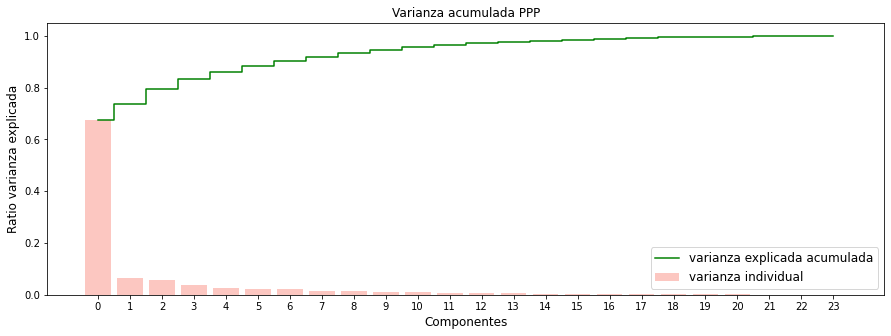

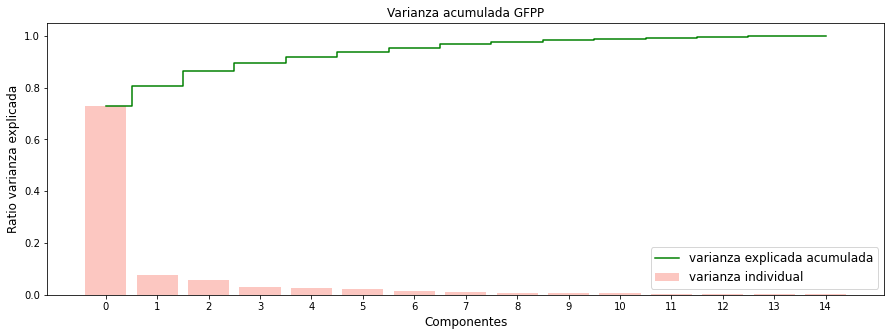

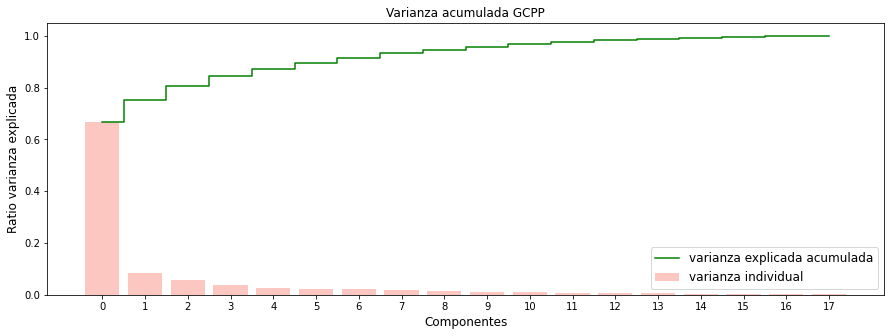

In [21]:
pca_d = {}

# Principal Component Analysis. Component selection
for response_var, featureScores in X_d.items():
    
    pca = PCA(n_components=len(X[X_d[response_var]].T))
    x_componentes = pca.fit_transform(X[X_d[response_var]])
    var_exp=pca.explained_variance_ratio_
    cum_var_exp=np.cumsum(var_exp)
    
        #Plot variance and cumulative variance along with the components.
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(var_exp)), var_exp, alpha=0.44, align='center', label='varianza individual', color = 'salmon')
    plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='varianza explicada acumulada',color='g')
    plt.xticks(ticks=range(len(cum_var_exp)))
    plt.ylabel('Ratio varianza explicada', fontsize=12)
    plt.xlabel('Componentes', fontsize=12)
    plt.legend(loc='lower right',fontsize=12)
    plt.title('Varianza acumulada '+ response_var)
    plt.show()
    
    
    #Select number if componets ie: cum_var_exp greater than 0.75
    n_components = [idx+1 for idx, cum_var in enumerate(cum_var_exp) if cum_var >=0.75]

    pca_pc = PCA(n_components = n_components[0])
    X_pc= pca_pc.fit_transform(X[X_d[response_var]])
    
    pca_d[response_var] = pca_pc

In [28]:

for response_var, pca in pca_d.items():
    
    y = response_vars_grouped.loc[:,response_var]
    
    #split the dataset into training (70%) and testing (30%) sets
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 
    
    #scale the training and testing data
    X_reduced_train = pca.fit_transform(scale(X_train))
    X_reduced_test = pca.transform(scale(X_test))[:,:1]
    
    #train PCR model on training data 
    regr = LinearRegression()
    regr.fit(X_reduced_train[:,:1], y_train)
    
    #calculate RMSE
    pred = regr.predict(X_reduced_test)
    print('RMSE for',response_var,'is',np.sqrt(mean_squared_error(y_test, pred)), 'range [',y.min(),
          ',',y.max(),']')

RMSE for PPP is 0.3084329038518823 range [ 0.4666666666666667 , 2.676470588235294 ]
RMSE for GFPP is 0.323373742843353 range [ 0.6052631578947368 , 2.8823529411764706 ]
RMSE for GCPP is 0.3295814076076426 range [ 0.5333333333333333 , 2.411764705882353 ]


# Conclusions
Only with the features obtained with FIFA22, we cannot accurately infer the performance in terms of points, 
goals scored or conceded of the teams studied. However, we have managed to detect characteristics that we see have 
some correlation with these values. We can conclude that some player performance parameters in FIFA22 are predictors 
of sports performance for their teams in the real world, beyond the game.